In [1]:
import pandas as pd
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
import re
from unidecode import unidecode

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
df.head()

,song_owner,song_title,song_element,verse,artist
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino


In [4]:
model_df = df.copy()

model_df = model_df[model_df['artist'] == 'Drake']

In [5]:
model_df['verse_words'] = model_df['verse'].copy()
model_df['verse_words'] = model_df['verse_words'].str.lower()
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.replace(',',''))
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.split(' '))

In [6]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words
1282,Drake,Buried Alive (Interlude),[Intro],"If you was in a pine box, I would surely break...",Drake,"[if, you, was, in, a, pine, box, i, would, sur..."
1284,Drake,God's Plan,[Intro],"Yeah, they wishin' and wishin' and wishin' and...",Drake,"[yeah, they, wishin', and, wishin', and, wishi..."
1285,Drake,God's Plan,[Verse 1],"I been movin' calm, don't start no trouble wit...",Drake,"[i, been, movin', calm, don't, start, no, trou..."
1286,Drake,God's Plan,[Chorus 1],"God's plan, God's plan, I hold back, sometimes...",Drake,"[god's, plan, god's, plan, i, hold, back, some..."
1287,Drake,God's Plan,[Post-Chorus],"And still, bad things, It's a lot of bad thing...",Drake,"[and, still, bad, things, it's, a, lot, of, ba..."


In [7]:
from nltk.tokenize import word_tokenize
model_df['tokenize_verse'] = model_df['verse'].copy()
model_df['tokenize_verse'] = model_df['tokenize_verse'].str.lower()
model_df['tokenize_verse'] = model_df['tokenize_verse'].apply(lambda x: word_tokenize(x))

In [8]:
model_df['verse'] = model_df['verse'].str.lower()
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace("'",''))
model_df['verse'] = model_df['verse'].apply(lambda x: "".join([c if c.isalnum() else " " for c in x ]))
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace('  ',' '))

In [9]:
stopwords = ["yeah", "uh", "huh", "aw", "oh", "la", "ayy",
            "na", "ha", "ay", "skrrt",
            "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
            "ba", "duh", "du", "1", "2", "3", "4" ,"5" ,"6", "7", "8", "9", "0"]

for index, row in model_df.iterrows():
    querywords = row['verse'].split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    row['verse'] = ' '.join(resultwords)

model_df.verse[:5]

1282    if you was in a pine box i would surely break ...
1284    they wishin and wishin and wishin and wishin t...
1285    i been movin calm dont start no trouble with m...
1286    gods plan gods plan i hold back sometimes i wo...
1287    and still bad things its a lot of bad things t...
Name: verse, dtype: object

In [10]:
verses = list(model_df.verse.values)

In [11]:
verses[:10]

['if you was in a pine box i would surely break the lock id jump right in and fall asleep cause you are the death of me if you was in a pine box i would surely break the lock id jump right in and fall asleep cause you are the death of me',
 'they wishin and wishin and wishin and wishin they wishin on me yuh',
 'i been movin calm dont start no trouble with me tryna keep it peaceful is a struggle for me dont pull up at am to cuddle with me you know how i like it when you lovin on me i dont wanna die for them to miss me yes i see the things that they wishin on me hope i got some brothers that outlive me they gon tell the story shit was different with me',
 'gods plan gods plan i hold back sometimes i wont yuh i feel good sometimes i dont dont i finessed down weston road nessed might go down a g o d wait i go hard on southside g yuh wait i make sure that north side eat',
 'and still bad things its a lot of bad things that they wishin and wishin and wishin and wishin they wishin on me bad t

In [12]:
all_verses_all_rappers = ','.join(verses)

all_verses_all_rappers[:100]

'if you was in a pine box i would surely break the lock id jump right in and fall asleep cause you ar'

In [13]:
file = all_verses_all_rappers

In [14]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file_len = len(file)
print(f'file_len = {file_len}')

file_len = 718122


In [15]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ser much closer all of my lets just be friends are friends i dont have anymore guess thats what they say you need family for cause i cant depend on you anymore,always saw you for what you couldve been ever since you met me like when chrysler made that one car that looked just like the bentley i always saw you for what you couldve been and even when its business with you its personal again i knew yo


In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

In [17]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis0123abczABC'))

tensor([48, 14, 29, 18, 28,  0,  1,  2,  3, 10, 11, 12, 35, 36, 37, 38])


In [18]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

In [19]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

In [20]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [21]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [22]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 12s (100 10%) 1.9407]
A foud dre dkez hay a dey to cith ow now weke knou roy sthat junt tobs tant tusd ig at sis yeou ars wh 

 23s (200 20%) 1.9283]
A man a me the and auming othing toand some jurrnt weone the want it dimcant arning tthe you done me o 

 28s (300 30%) 1.4400]
A back went man i gueted niggas a rey call all you that ald so min s the like it out just to carin to  

 38s (400 40%) 1.6912]
A anow your cant the know and fave you keart i was you dont i my to startion i they bitper nawe and do 

 43s (500 50%) 1.3610]
A i prast was so great the for pance how of for brom been you mese dont with that i go here tell tere  

 49s (600 60%) 1.4646]
A thing the still i gottle doin of you are a worf lessied than you shit the lot she dont now me side f 

 56s (700 70%) 1.7581]
A i out that just like a know im they know in many im out im get toubtione when crank i ming i canlin  

 1s (800 80%) 3.5025]
A just all hear do like what year that come begotto gon all about all be girl afte

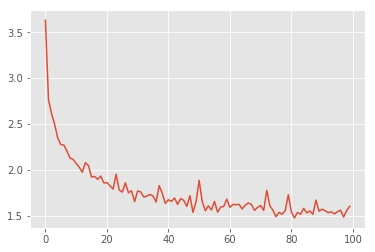

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [24]:
with open('models/drake_rnn_generator.pkl', 'wb') as picklefile:
    pickle.dump(model, picklefile)

In [25]:
# Evaluate model from this notebook
print(evaluate(model, 'To be or not to be: ', predict_len=200, temperature=0.5))

To be or not to be: and not the time bout the mother and long they girl i dont way i know in the family do when i as get the really dont as still been i dont they just the what your better im got the hot the bottom betti


In [26]:
# Evaluate model from this notebook
print(evaluate(model, 'I miss you girl come back ', predict_len=200, temperature=0.5))

I miss you girl come back and to switch like i dont mary stop i dont not right look now some flow on your niggas its they ass a rememiss for the started for and got the never say its yours up got the madies i have now you see 


In [27]:
# Evaluate model from this notebook
print(evaluate(model, "Started from the bottom", predict_len=200, temperature=0.4))

Started from the bottom that not im no bout the bottom need my new its on my still be see that shit i how i dont like now i for she see the started its for let the family not i like the fight to be when its on the see it on


In [28]:
# Evaluate model from this notebook
print(evaluate(model, "I'm the realest rapper alive", predict_len=200, temperature=0.4))

I'm the realest rapper alive the same i cant here so im airs and is on the morthing like yours sound still when i want they started the night some its the lights now like that im still for my one better shit the fucking not all 


In [29]:
# Evaluate model from this notebook
print(evaluate(model, "Smoke a lot of weed", predict_len=200, temperature=0.4))

Smoke a lot of weed what you cant the fairs so i dont got for got of me the bottom these days to remits i see the got the got stop of my feeling try the started so i dont should got really got all of the try the stop th


In [30]:
# Evaluate model from this notebook
print(evaluate(model, "Baby come", predict_len=200, temperature=0.4))

Baby come started its and say the mother been on my money that im really for it somebody started the still let the fails shit the whole never and im say its to the fuck im feel strick the lot for you need the 
